In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import logging 

In [20]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

def preprocess_data(full_df, target_col='Outperform', drop_cols=['PRICE VAR [%]', 'class', 'symbol']):
    """
    Preprocess the dataset by splitting into training, validation, and test sets,
    and standardizing features with StandardScaler (no SMOTE).
    
    Parameters:
    - full_df: pd.DataFrame, the full merged dataset
    - target_col: str, the target variable name ('Outperform')
    - drop_cols: list, columns to drop due to data leakage or irrelevance
    
    Returns:
    - X_train_scaled, X_val_scaled, X_test_scaled: scaled feature matrices for train, validation, and test sets
    - y_train, y_val, y_test: target variables for train, validation, and test sets
    - scaler: the StandardScaler object fitted on the training data
    """
    
    # Split the data by year ranges
    train_years = list(range(2000, 2017))
    val_years = [2017, 2018]
    test_years = list(range(2019, 2023))
    
    # Create train, validation, and test sets
    train_data = full_df[full_df['year'].isin(train_years)]
    val_data = full_df[full_df['year'].isin(val_years)]
    test_data = full_df[full_df['year'].isin(test_years)]
    
    logging.info(f"Training data size: {train_data.shape}")
    logging.info(f"Validation data size: {val_data.shape}")
    logging.info(f"Test data size: {test_data.shape}")
    
    # Drop the columns that may cause data leakage and separate target
    X_train = train_data.drop(columns=drop_cols + [target_col])
    y_train = train_data[target_col]
    
    X_val = val_data.drop(columns=drop_cols + [target_col])
    y_val = val_data[target_col]
    
    X_test = test_data.drop(columns=drop_cols + [target_col])
    y_test = test_data[target_col]
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler


def preprocess_data_with_smote(full_df, target_col='Outperform', drop_cols=['PRICE VAR [%]', 'class', 'symbol']):
    """
    Preprocess the dataset by splitting into training, validation, and test sets,
    applying SMOTE to the training data, and standardizing features with StandardScaler.
    
    Parameters:
    - full_df: pd.DataFrame, the full merged dataset
    - target_col: str, the target variable name ('Outperform')
    - drop_cols: list, columns to drop due to data leakage or irrelevance
    
    Returns:
    - X_train_scaled, X_val_scaled, X_test_scaled: scaled feature matrices for train, validation, and test sets
    - y_train_smote, y_val, y_test: target variables for train, validation, and test sets
    - scaler: the StandardScaler object fitted on the training data
    - X_train: original X_train before SMOTE and scaling, to be used for feature names
    """
    
    # Split the data by year ranges
    train_years = list(range(2000, 2017))
    val_years = [2017, 2018]
    test_years = list(range(2019, 2023))
    
    # Create train, validation, and test sets
    train_data = full_df[full_df['year'].isin(train_years)]
    val_data = full_df[full_df['year'].isin(val_years)]
    test_data = full_df[full_df['year'].isin(test_years)]
    
    logging.info(f"Training data size: {train_data.shape}")
    logging.info(f"Validation data size: {val_data.shape}")
    logging.info(f"Test data size: {test_data.shape}")
    
    # Drop the columns that may cause data leakage and separate target
    X_train = train_data.drop(columns=drop_cols + [target_col])
    y_train = train_data[target_col]
    
    X_val = val_data.drop(columns=drop_cols + [target_col])
    y_val = val_data[target_col]
    
    X_test = test_data.drop(columns=drop_cols + [target_col])
    y_test = test_data[target_col]
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    logging.info(f"Training data size after SMOTE: {X_train_smote.shape}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_smote)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_smote, y_val, y_test, scaler, X_train  # Return X_train for feature names


def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Train the model and evaluate it on validation data, including confusion matrix and classification report.
    
    Parameters:
    - model: the machine learning model to train
    - X_train: training features
    - y_train: training labels
    - X_val: validation features
    - y_val: validation labels
    
    Returns:
    - classification report and confusion matrix
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation data
    y_pred = model.predict(X_val)
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    
    # Classification Report
    report = classification_report(y_val, y_pred)
    print(f"Classification Report for {model.__class__.__name__}:\n")
    print(report)
    
    return y_pred


# Load the full dataset
df = pd.read_csv('data/cleaned_data/modeling_data/full_Financial_Data_for_modeling.csv')

# Preprocess the data
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler, X_train = preprocess_data_with_smote(df)
# Example to see the first 5 rows of the training set
print("First 5 rows of the scaled training set:")

X_train_scaled[:5]


2024-10-11 11:26:31,049 - Training data size: (69262, 227)
2024-10-11 11:26:31,050 - Validation data size: (15395, 227)
2024-10-11 11:26:31,050 - Test data size: (40242, 227)
2024-10-11 11:26:32,009 - Training data size after SMOTE: (87398, 223)


First 5 rows of the scaled training set:


array([[-1.93662159,  0.39349797, -0.46021437, ..., -0.05868898,
        -0.16292679,  0.        ],
       [-1.93662159, -0.49320454, -0.46715189, ..., -0.05868898,
        -0.16292679,  0.        ],
       [-1.93662159,  0.39349797, -0.46021437, ..., -0.05868898,
        -0.16292679,  0.        ],
       [-1.93662159,  0.39349797, -0.46715189, ..., -0.05868898,
        -0.16292679,  0.        ],
       [-1.93662159,  0.02564163, -0.46715189, ..., -0.05868898,
        -0.16292679,  0.        ]])

In [4]:
df = pd.read_csv('data/cleaned_data/modeling_data/full_Financial_Data_for_modeling.csv')
df.head()

,symbol,year,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,...,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Unknown,Sector_Utilities,Sector_Consumer Services
0,0HRJ.L,2000.0,1.756821e+08,114315.0,245707600.0,387966250.0,88063455.0,1.483007e+09,777669500.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0HST.L,2000.0,2.700000e+07,0.0,27000000.0,387966250.0,88063455.0,1.168000e+09,777669500.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,0JVQ.L,2000.0,1.756821e+08,114315.0,245707600.0,160985000.0,88063455.0,1.483007e+09,777669500.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0KXA.L,2000.0,1.756821e+08,0.0,190000000.0,387966250.0,88063455.0,1.483007e+09,777669500.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0LWH.L,2000.0,1.140000e+08,0.0,114000000.0,387966250.0,88063455.0,1.483007e+09,777669500.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## 2. Training the Random Forest Model

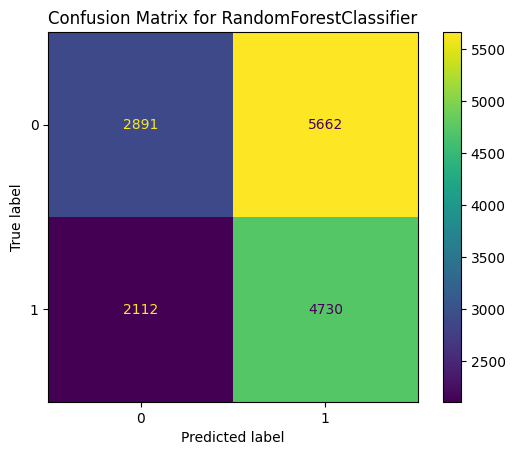

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

         0.0       0.58      0.34      0.43      8553
         1.0       0.46      0.69      0.55      6842

    accuracy                           0.50     15395
   macro avg       0.52      0.51      0.49     15395
weighted avg       0.52      0.50      0.48     15395



In [5]:
# Run
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Call the function to train and evaluate the model
y_pred_rf = train_and_evaluate_model(rf, X_train_scaled, y_train, X_val_scaled, y_val)

## 3. Hyperparameter Tuning with GridSearchCV

In [6]:
# Initialize GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7],  
    'min_samples_split': [10, 20], 
    'max_features': ['sqrt'],  
    'class_weight': [None, {0: 1, 1: 4}, {0: 1, 1: 6}],  
    'min_samples_leaf': [5, 10],  
}
# param_grid = {
#     'n_estimators': [100, 200, 300],  # More trees for better stability
#     'max_depth': [10, 20, 30],  # Increased depth for more complex splits
#     'min_samples_split': [5, 10],  # Conservative splits
#     'min_samples_leaf': [2, 5],  # Conservative leaf sizes
#     'max_features': ['sqrt', 'log2'],  # Feature selection strategies
#     'class_weight': ['balanced', {0: 1, 1: 4}, {0: 1, 1: 6}]  # Lower class 1 weight to avoid overcompensation
# }
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring='balanced_accuracy',  # desired metric
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Save the search progress periodically
checkpoint_filename = 'grid_search_checkpoint.pkl'

try:
    grid_search.fit(X_train_scaled, y_train)
except KeyboardInterrupt:
    # Save the current state of the GridSearchCV object
    joblib.dump(grid_search, checkpoint_filename)
    print(f'Search interrupted and saved to {checkpoint_filename}')

# If interrupted, you can load the previous checkpoint and resume
# grid_search = joblib.load(checkpoint_filename)

# Best parameters
if hasattr(grid_search, 'best_params_'):
    print("Best parameters found:", grid_search.best_params_)
    
    # Use the best estimator to make predictions
    best_rf = grid_search.best_estimator_
    y_pred_best = best_rf.predict(X_test_scaled)

    # Evaluate the optimized model
    print(classification_report(y_test, y_pred_best))
else:
    print('Search did not complete or no best parameters were found.')



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'class_weight': {0: 1, 1: 6}, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.69      0.14      0.23     27580
         1.0       0.31      0.86      0.46     12662

    accuracy                           0.37     40242
   macro avg       0.50      0.50      0.35     40242
weighted avg       0.57      0.37      0.30     40242



## 4. Adjusting the Classification Threshold

In [12]:
# Check if best model is available
if hasattr(grid_search, 'best_params_'):
    print("Best parameters found:", grid_search.best_params_)
    
    # Use the best estimator to make predictions
    best_rf = grid_search.best_estimator_
    y_pred_best = best_rf.predict(X_test_scaled)

    # Evaluate the optimized model
    print(classification_report(y_test, y_pred_best))
else:
    print('Search did not complete or no best parameters were found.')



Best parameters found: {'class_weight': {0: 1, 1: 6}, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.69      0.14      0.23     27580
         1.0       0.31      0.86      0.46     12662

    accuracy                           0.37     40242
   macro avg       0.50      0.50      0.35     40242
weighted avg       0.57      0.37      0.30     40242



## 5. Feature Importance Analysis


                                Feature  Importance
205                 10yr_treasury_yield    0.152601
0                                  year    0.073542
206                       inflationRate    0.067287
9           goodwillAndIntangibleAssets    0.061491
10                            taxAssets    0.049886
..                                  ...         ...
124  growthSalesMaturitiesOfInvestments    0.000000
123        growthPurchasesOfInvestments    0.000000
122               growthAcquisitionsNet    0.000000
120             growthOtherNonCashItems    0.000000
222            Sector_Consumer Services    0.000000

[223 rows x 2 columns]


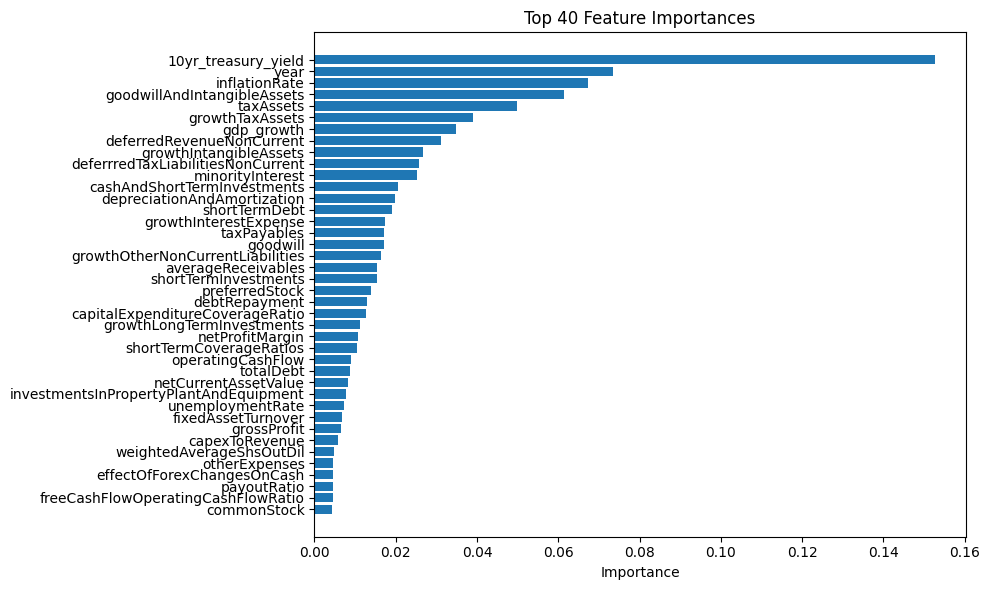

In [22]:
# Assuming X_train was used during training
importances = best_rf.feature_importances_
feature_names = X_train.columns  # Ensure X_train is defined

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feat_imp_df)

# Visualize the top 20 most important features
top_n = 40
top_feat_imp_df = feat_imp_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_feat_imp_df['Feature'], top_feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()



In [ ]:
pd.set_option('display.max_rows', None)
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
feat_imp_df

In [ ]:
# Save the trained model to a file
model_filename = 'best_rf_model.joblib'
joblib.dump(best_rf, model_filename)